In [206]:
import numpy as np 
import torch 
import pandas as pd
import yfinance as yf
from arch import arch_model
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.optimize import minimize
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import json
import os 
from datetime import datetime
import torch.nn.functional as F
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [207]:
def generate_ground_figarch(omega, d, alpha, beta, n=1000):
    
    am = arch_model(None, mean='Zero', vol='GARCH', p=1, q=1, power = 2) #Остатки просто получаются умножением волатильности на кси ~N(0,1)
    params = np.array([omega, d, alpha, beta])
    am_data = am.simulate(params, n)

    return am_data['data'].to_numpy(), am_data['volatility'].to_numpy()

In [208]:
omega = 0.1  
d = 0.4
phi_1 = 0.2
beta_1 = 0.3

data, volatility = generate_ground_figarch(omega, d, phi_1, beta_1, n=1000)

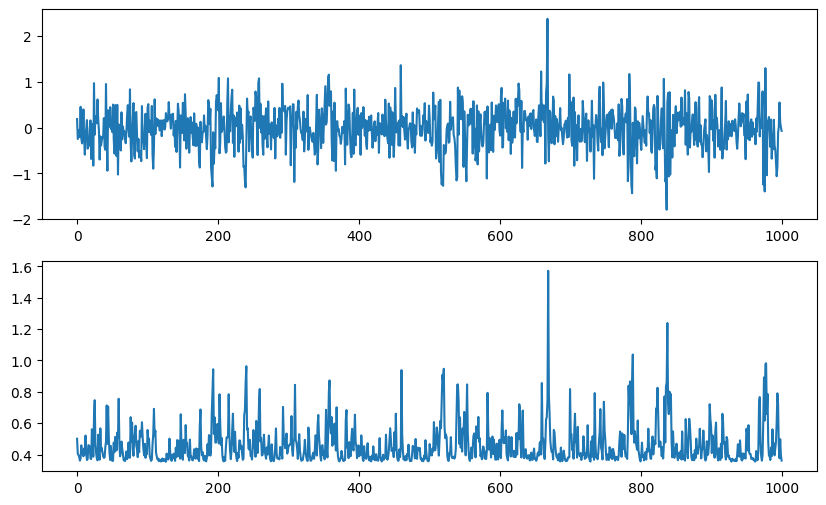

In [209]:
fig, axs = plt.subplots(2, figsize = (10, 6))
axs[0].plot(data)
axs[1].plot(volatility)
plt.show()

In [210]:
class FIGARCHDataset(Dataset):
    def __init__(self, epsilon_sq_series,volatility, truncation_size, window_step=1, scale = 100):
        """
        Args:
            epsilon_sq_series: 1D массив квадратов остатков [eps_1^2, eps_2^2, ..., eps_n^2]
            truncation_size: размер усечения T (размер ядра свертки)
            window_step: шаг скользящего окна
        """

        self.scale = scale
        self.epsilon_sq = torch.FloatTensor(epsilon_sq_series*self.scale)
        self.T = truncation_size
        self.step = window_step
        self.volatility = volatility * self.scale
        # Вычисляем допустимые индексы для выборок
        self.valid_indices = range(self.T - 1, len(self.epsilon_sq) - 1, self.step)
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        """Возвращает:
            X: окно квадратов остатков [eps_{t-T+1}^2, ..., eps_t^2]
            y: целевое значение (eps_{t+1}^2 для прогнозирования)
        """
        t = self.valid_indices[idx]
        X = self.epsilon_sq[t-self.T+1 : t+1]  # Окно размером T
        y = self.volatility[t+1]               # Следующее значение для прогноза
        
        return X, y
    

In [ ]:
class FIGARCHDataModule(pl.LightningDataModule):
    def __init__(self, epsilon_series, volatility, truncation_size=10, 
                 batch_size=32, train_ratio=0.8, scale=100):
        super().__init__()
        self.epsilon_sq = (epsilon_series ** 2) * scale
        self.volatility = volatility * scale
        self.T = truncation_size
        self.batch_size = batch_size
        self.scale = scale
        
    
    def setup(self, stage = None):
        if stage == 'fit' or stage is None:
            self.train_dataset = FIGARCHDataset(data, volatility, truncation_size=10)


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False)

In [212]:
class CorrectedNLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, pred_var, target_eps_squared):
        loss =  (0.5*(torch.log(pred_var)) + (target_eps_squared/(2*pred_var))) 
        return loss.mean()

In [ ]:
class FIGARCH_CNN(pl.LightningModule):
    def __init__(self, truncation_size):
        super().__init__()
        self.T = truncation_size
        

        self.conv = nn.Conv1d(1, 1, kernel_size=truncation_size, bias=False)

In [214]:
ground_truth = (omega, d, phi_1, beta_1)

In [ ]:
dm = FIGARCHDataModule(data, volatility, truncation_size=10, batch_size=32)
model = FIGARCH_CNN(truncation_size=20)

In [216]:
logger = TensorBoardLogger('tb_logs', name= 'figarch_model')

In [217]:
trainer = pl.Trainer(
        max_epochs=100,
        accelerator="auto",
        logger=logger
    )


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [218]:

trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type           | Params | Mode 
--------------------------------------------------------
0 | loss_fn      | CorrectedNLoss | 0      | train
  | other params | n/a            | 4      | n/a  
--------------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (31) is smaller than the logging inte

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same